In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import spacy
from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('corpus')

# Configurar visualización
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\mathi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading corpus: Package 'corpus' not found in index


In [101]:
#Cargamos los csv EDA
subreddit_data = pd.read_csv('../data/subreddit_data.csv')
posts_data = pd.read_csv('../data/posts_data.csv')
subreddit_data = subreddit_data.fillna("")
posts_data = posts_data.fillna("")
combined_data = posts_data.merge(subreddit_data, on='subreddit_id', how='left')

# Tokenizacion y Lematizacion

In [102]:
class RedditTextProcessor:
    def __init__(self):
        # Inicializar el lematizador
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.columns_to_process = ["titlePost", "tittleSubreddit", "descriptionReddit"]

    def preprocess_text(self, text):
        # Tokenización
        text = str(text)
        tokens = word_tokenize(text.lower())
        # Lematización y filtrado de stopwords
        tokens = [
            self.lemmatizer.lemmatize(token) for token in tokens 
            if token.isalpha() and token not in self.stop_words
        ]
        # Se devuelve una cadena y no una lista de tokens para los modelos de aprendizaje
        return " ".join(tokens)
    
    def process_dataframe(self, df):
        for column in df.columns:
            if df[column].dtype == object and column  in self.columns_to_process:
                df[column] = df[column].apply(self.preprocess_text)
        return df

In [103]:
textProcessor = RedditTextProcessor()
processed_data = textProcessor.process_dataframe(combined_data)

# Clustering

Para k=2, el coeficiente de silueta es 0.33205754246393054
Para k=3, el coeficiente de silueta es 0.32617074849305244
Para k=4, el coeficiente de silueta es 0.18816550368803797
Para k=5, el coeficiente de silueta es 0.19518496190747162
Para k=6, el coeficiente de silueta es 0.11466784115015315
Para k=7, el coeficiente de silueta es 0.07750127287764849
Para k=8, el coeficiente de silueta es 0.050632438051335056
Para k=9, el coeficiente de silueta es 0.05094367131241457


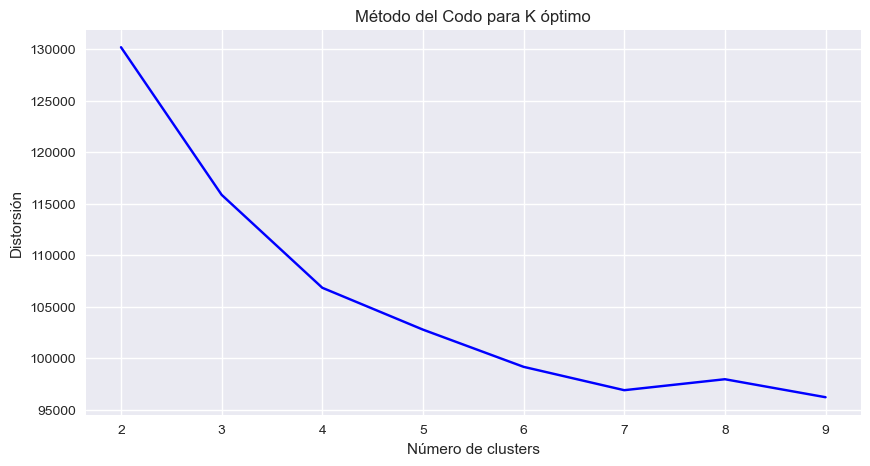

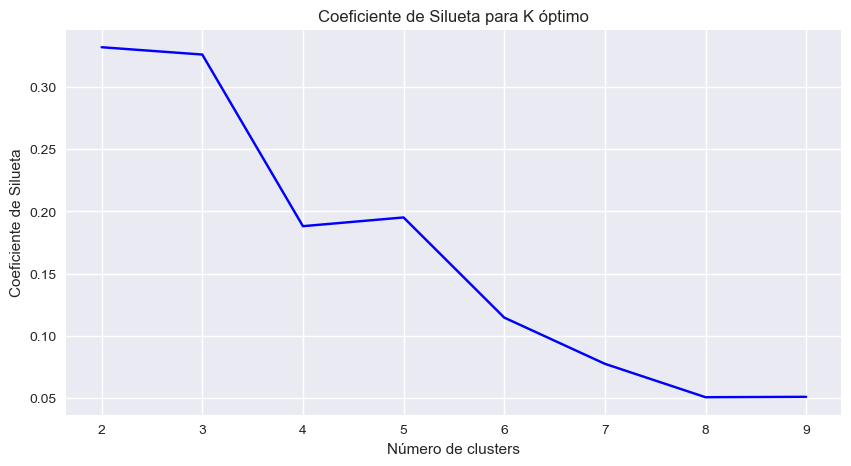

In [104]:
class RedditClustering:
    def __init__(self, processed_data):
        #Transformacion de texto a valor numerica para procesar datos
        self.vectorizer_title = TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')
        self.vectorizer_subreddit = TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')
        self.vectorizer_description = TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')

        tfidf_title = self.vectorizer_title.fit_transform(processed_data['titlePost'])
        tfidf_subreddit = self.vectorizer_subreddit.fit_transform(processed_data['tittleSubreddit'])
        tfidf_description = self.vectorizer_description.fit_transform(processed_data['descriptionReddit'])

        combined_tfidf = hstack([tfidf_title, tfidf_subreddit, tfidf_description])

        post_numeric_features  = StandardScaler().fit_transform(processed_data[['upVotes', 'scorePost', 'commentsPost']])
        self.combined_features = hstack([combined_tfidf, post_numeric_features])
        
        
    def get_k_values(self):
        distortions = []
        silhouette_scores = []
        K = range(2, 10)
        for k in K:
            kmeans_model = KMeans(n_clusters=k, random_state=42)
            kmeans_model.fit(self.combined_features)
            distortions.append(kmeans_model.inertia_)
            silhouette_avg = silhouette_score(self.combined_features, kmeans_model.labels_)
            silhouette_scores.append(silhouette_avg)
            print(f"Para k={k}, el coeficiente de silueta es {silhouette_avg}")

        # Visualización del método del codo
        plt.figure(figsize=(10, 5))
        plt.plot(K, distortions, 'bx-')
        plt.xlabel('Número de clusters')
        plt.ylabel('Distorsión')
        plt.title('Método del Codo para K óptimo')
        plt.show()

        # Visualización del coeficiente de silueta
        plt.figure(figsize=(10, 5))
        plt.plot(K, silhouette_scores, 'bx-')
        plt.xlabel('Número de clusters')
        plt.ylabel('Coeficiente de Silueta')
        plt.title('Coeficiente de Silueta para K óptimo')
        plt.show()

    def apply_kmeans(self, k, df):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(self.combined_features)
        clusters = kmeans.labels_
        df['Cluster'] = clusters
        score = silhouette_score(self.combined_features, clusters)
        print("Silhouette Score para clusters:", score)
        return df


clustering = RedditClustering(processed_data)
clustering.get_k_values()


In [ ]:
processed_data = clustering.apply_kmeans(50, processed_data)
print(processed_data.head())

Silhouette Score para clusters: 0.057533880345081514
   subreddit_id                                          titlePost  \
0             0                             price range house like   
1             0                                        door garage   
2             0                     fix garage door torsion spring   
3             0                                   call type design   
4             0  inspector said termite damage year old house m...   

           createdPost  scorePost  upVotedRatio  upVotes  commentsPost  \
0  2023-08-18 10:17:43      11633          0.92    11633          1727   
1  2023-05-18 16:41:57       6026          0.96     6026          1700   
2  2023-08-26 19:44:33       5581          0.86     5581          3644   
3  2023-08-21 17:37:07       2824          0.96     2824           579   
4  2023-07-28 17:40:05       2692          0.94     2692           952   

  tittleSubreddit  subscribersReddit descriptionReddit        createdReddit  \
0 